In [1]:
%matplotlib inline
# python libraties
import os, itertools, cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [2]:
data_path = '../input/data'
train_data_path = glob(os.path.join(data_path,'train','images','*','*'))
val_data_path = glob(os.path.join(data_path,'train','images','*','*'))

In [3]:
from collections import defaultdict
# train_data_dir = sorted(glob(os.path.join(data_path,'train','images','*')))
train_data_dir = glob(os.path.join(data_path,'train','images','*'))
print('num of directory',len(train_data_dir))
print('num of file',len(train_data_path))
num_ext = defaultdict(int)
for file in train_data_path:
    ext = file.split('.')[-1]
    if ext not in num_ext.keys():
        num_ext[ext]+=1
    else:
        num_ext[ext]+=1
print(num_ext)

num of directory 2700
num of file 18900
defaultdict(<class 'int'>, {'png': 511, 'jpg': 18035, 'jpeg': 354})


In [4]:
# under this extension, all are 7
for file_idx in sorted(train_data_dir,reverse=True):
    if len(glob(os.path.join(file_idx,'*'))) != 7:
           print(file_idx, len(glob(os.path.join(file_idx,'*.jpg'))))

In [5]:
# image size test (even though already given)
test_img = cv2.imread(train_data_path[0])
base_shape = test_img.shape
for idx in range(len(train_data_path)):
    test_img = cv2.imread(train_data_path[idx])
    if test_img.shape != (512,384,3):
        print(idx, test_img.shape)

In [6]:
# image pixel check


In [7]:
# labelding preprocessing

In [8]:
df_train = pd.read_csv(os.path.join(data_path, 'train', 'train.csv'))
df_val = pd.read_csv(os.path.join(data_path, 'eval', 'info.csv'))
print('folder info',len(df_train))
print('img info',len(train_data_path))
df_train.head(10)

folder info 2700
img info 18900


,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
5,000007,female,Asian,58,000007_female_Asian_58
6,000008,female,Asian,58,000008_female_Asian_58
7,000009,female,Asian,56,000009_female_Asian_56
8,000010,female,Asian,58,000010_female_Asian_58
9,000012,male,Asian,57,000012_male_Asian_57


In [9]:
df_train.isnull().sum()

id        0
gender    0
race      0
age       0
path      0
dtype: int64

In [10]:
# test case
test_dict = {'age':[0,20,29,30,59,60,71],
            'gender':['F','M','M','F','M','F','M']}
test_df = pd.DataFrame(test_dict)
bin_range = [0,30,60,np.inf]
test_df['age_type'] = pd.cut(x=test_df['age'],
                             bins = bin_range,
                             right=False,
                             include_lowest=True,
                             labels=[0,1,2])
# filters = [
#     (test_df['age_type']==0) & (test_df['gender']=='F'),
#     (test_df['age_type']==0) & (test_df['gender']=='M'),
#     (test_df['age_type']==1) & (test_df['gender']=='F'),
#     (test_df['age_type']==1) & (test_df['gender']=='M'),
# ]

filters = [
    (test_df['age']<30) & (test_df['gender']=='F'),
    (test_df['age']<30) & (test_df['gender']=='M'),
    (test_df['age']>=30) & (test_df['age']<60) & (test_df['gender']=='M'),
    (test_df['age']>=30) & (test_df['age']<60) & (test_df['gender']=='F'),
]

values = list(range(4))
test_df['new_labels'] = np.select(filters, values)
# test_df['new_labels'] = np.where((test_df['age_type']==0) & (test_df['gender']=='F'),'bad','good')
test_df

,age,gender,age_type,new_labels
0,0,F,0,0
1,20,M,0,1
2,29,M,0,1
3,30,F,1,3
4,59,M,1,2
5,60,F,2,0
6,71,M,2,0


count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64


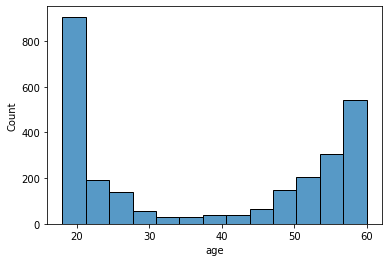

In [11]:
import seaborn as sns
sns.histplot(df_train['age'])
print(df_train['age'].describe())

In [12]:
df_train['age'].max()

60

In [13]:
# 연속형의 범주화 -> np.digitize, pd.cut이용
# https://rfriend.tistory.com/521
bin_range = list(range(0,61,30))
bin_range.append(np.inf)
df_train['age_level']=pd.cut(x=df_train['age'],
                            bins=bin_range,
                            right=False,
                            include_lowest=True,
                            labels=[0,1,2])
df_train

,id,gender,race,age,path,age_level
0,000001,female,Asian,45,000001_female_Asian_45,1
1,000002,female,Asian,52,000002_female_Asian_52,1
2,000004,male,Asian,54,000004_male_Asian_54,1
3,000005,female,Asian,58,000005_female_Asian_58,1
4,000006,female,Asian,59,000006_female_Asian_59,1
...,...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19,0
2696,006955,male,Asian,19,006955_male_Asian_19,0
2697,006956,male,Asian,19,006956_male_Asian_19,0
2698,006957,male,Asian,20,006957_male_Asian_20,0


In [14]:
new_dict = {'id':[],
            'gender':[],
            'race':[],
            'age':[],
            'mask':[],
            'path':[],
           'dir':[]}
data_path = '../input/data'
for idx, df_train_data in enumerate(df_train.iterrows()):
    data_dir = glob(os.path.join(data_path,'train','images',df_train_data[1].path,'*'))
    for data_file in data_dir:
        if 'incorrect' in os.path.basename(data_file):
            new_dict['mask'].append('incorrect')
        elif 'normal' in os.path.basename(data_file):
            new_dict['mask'].append('not_wear')
        else:
            new_dict['mask'].append('wear')
        new_dict['id'].append(df_train_data[1].id)
        new_dict['gender'].append(df_train_data[1].gender)
        new_dict['race'].append(df_train_data[1].race)
        new_dict['age'].append(df_train_data[1].age)
        new_dict['path'].append(data_file)
        new_dict['dir'].append(df_train_data[1].path)

new_train_df = pd.DataFrame(new_dict)
new_train_df

,id,gender,race,age,mask,path,dir
0,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
1,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
2,000001,female,Asian,45,not_wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
3,000001,female,Asian,45,incorrect,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
4,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
...,...,...,...,...,...,...,...
18895,006959,male,Asian,19,not_wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19
18896,006959,male,Asian,19,incorrect,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19
18897,006959,male,Asian,19,wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19
18898,006959,male,Asian,19,wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19


In [15]:
new_train_df['age'].dtype

dtype('int64')

In [16]:
filters = [
    (new_train_df['mask']=='wear')& (new_train_df['gender']=='male')& (new_train_df['age']<30),
    (new_train_df['mask']=='wear')& (new_train_df['gender']=='male')& (new_train_df['age']>=30) &  (new_train_df['age']<60),
    (new_train_df['mask']=='wear')& (new_train_df['gender']=='male')& (new_train_df['age']>=60),
    
    (new_train_df['mask']=='wear')& (new_train_df['gender']=='female')& (new_train_df['age']<30),
    (new_train_df['mask']=='wear')& (new_train_df['gender']=='female')& (new_train_df['age']>=30) &  (new_train_df['age']<60),
    (new_train_df['mask']=='wear')& (new_train_df['gender']=='female')& (new_train_df['age']>=60),

        (new_train_df['mask']=='incorrect')& (new_train_df['gender']=='male')& (new_train_df['age']<30),
    (new_train_df['mask']=='incorrect')& (new_train_df['gender']=='male')& (new_train_df['age']>=30) &  (new_train_df['age']<60),
    (new_train_df['mask']=='incorrect')& (new_train_df['gender']=='male')& (new_train_df['age']>=60),
    
    (new_train_df['mask']=='incorrect')& (new_train_df['gender']=='female')& (new_train_df['age']<30),
    (new_train_df['mask']=='incorrect')& (new_train_df['gender']=='female')& (new_train_df['age']>=30) &  (new_train_df['age']<60),
    (new_train_df['mask']=='incorrect')& (new_train_df['gender']=='female')& (new_train_df['age']>=60),
    
            (new_train_df['mask']=='not_wear')& (new_train_df['gender']=='male')& (new_train_df['age']<30),
    (new_train_df['mask']=='not_wear')& (new_train_df['gender']=='male')& (new_train_df['age']>=30) &  (new_train_df['age']<60),
    (new_train_df['mask']=='not_wear')& (new_train_df['gender']=='male')& (new_train_df['age']>=60),
    
    (new_train_df['mask']=='not_wear')& (new_train_df['gender']=='female')& (new_train_df['age']<30),
    (new_train_df['mask']=='not_wear')& (new_train_df['gender']=='female')& (new_train_df['age']>=30) &  (new_train_df['age']<60),
    (new_train_df['mask']=='not_wear')& (new_train_df['gender']=='female')& (new_train_df['age']>=60),
]

values = list(range(18))
new_train_df['targets'] = np.select(filters, values)
new_train_df

,id,gender,race,age,mask,path,dir,targets
0,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45,4
1,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45,4
2,000001,female,Asian,45,not_wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45,16
3,000001,female,Asian,45,incorrect,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45,10
4,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45,4
...,...,...,...,...,...,...,...,...
18895,006959,male,Asian,19,not_wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19,12
18896,006959,male,Asian,19,incorrect,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19,6
18897,006959,male,Asian,19,wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19,0
18898,006959,male,Asian,19,wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19,0


In [17]:
new_train_df.to_csv("./data/train/new_train_df.csv", mode='w')

In [18]:
# sever data imbalance
new_train_df['targets'].value_counts()

4     4085
3     3660
0     2745
1     2050
16     817
10     817
15     732
9      732
12     549
6      549
5      545
2      415
7      410
13     410
11     109
17     109
8       83
14      83
Name: targets, dtype: int64

In [19]:
new_train_df.isnull().sum()

id         0
gender     0
race       0
age        0
mask       0
path       0
dir        0
targets    0
dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
# random
train, valid = train_test_split(new_train_df,test_size=0.2,
                                    shuffle=True, stratify=new_train_df['targets'],
                               )

In [21]:
from glob import glob
import os
import pandas as pd
data_path = '../input/data'
val_data_path = glob(os.path.join(data_path,'eval','images','*'))
val_dict = {
            'path':[],
           'targets':[]}
data_path = '../input/data'
info_csv = pd.read_csv(os.path.join(data_path,'eval','info.csv'))
info_csv['ImageID']
for idx, (val, label) in enumerate(zip(sorted(val_data_path),sorted(info_csv['ans']))):
 
        val_dict['path'].append(val)
        
        val_dict['targets'].append(label)

In [22]:
val_df = pd.DataFrame(val_dict)
import numpy as np
np.unique(val_df['targets'])

array([0])

In [23]:
# sorted(val_data_path)
sorted(info_csv['ImageID'])
for idx,(v, i) in enumerate(zip(sorted(val_data_path), sorted(info_csv['ImageID']))):
    if os.path.basename(v)!= i:
        print(v, i)
    assert os.path.basename(v) == i

In [24]:
info_csv['ans']

0        0
1        0
2        0
3        0
4        0
        ..
12595    0
12596    0
12597    0
12598    0
12599    0
Name: ans, Length: 12600, dtype: int64